# BERT Fine Tuning Naver 영화감상평 분류

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU 사용 :", torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
    print("No GPU available, CPU 사용")

GPU 사용 : Tesla P100-PCIE-16GB


In [2]:
!pip install transformers

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import *

## Importing the dataset

In [0]:
DATA_TRAIN_PATH = tf.keras.utils.get_file("ratings_train.txt", 
                                "https://github.com/ironmanciti/NLP_lecture/raw/master/data/naver_movie/ratings_train.txt")
DATA_TEST_PATH = tf.keras.utils.get_file("ratings_test.txt", 
                                "https://github.com/ironmanciti/NLP_lecture/raw/master/data/naver_movie/ratings_test.txt")

In [5]:
train_data = pd.read_csv(DATA_TRAIN_PATH, delimiter='\t')
print(train_data.shape)
train_data.head()

(150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
train_data.dropna(inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [7]:
test_data = pd.read_csv(DATA_TEST_PATH, delimiter='\t')
print(test_data.shape)
test_data.head()

(50000, 3)


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [8]:
test_data.dropna(inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49997 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49997 non-null  int64 
 1   document  49997 non-null  object
 2   label     49997 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


몇개의 sentence 가 "positive" (value 1) 이고 몇개가  "negative" (having the value 0) 인지 count

In [9]:
df_train = train_data.sample(n=50000, random_state=1)
df_test = test_data.sample(n=5000, random_state=1)
print(df_train.shape)
print(df_test.shape)

(50000, 3)
(5000, 3)


In [10]:
df_train['label'].value_counts()

0    25069
1    24931
Name: label, dtype: int64

## Loading the Pre-trained BERT model

### BertModel
- Bert 모델 변환기는 top layer 가 제거된 raw hidden state 를 출력
- 반환값:
    - last_hidden_state (torch.FloatTensor of shape (batch_size, sequence_length, hidden_size)): Sequence of hidden-states at the output of the last layer of the model.

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

model = BertModel.from_pretrained('bert-base-multilingual-cased')

## Model #1: Preparing the Dataset
문장을 BERT에 전달하려면 먼저 필요한 형식으로 문장을 처리하기 위해 최소한의 처리가 필요합니다.

### Tokenization
첫 번째 단계는 문장을 토큰화하는 것입니다. BERT가 원하는 형식으로 word 와 subword 로 나눕니다.

In [12]:
%%time
tokenized_train = df_train['document'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_test = df_test['document'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

CPU times: user 10.2 s, sys: 84.4 ms, total: 10.3 s
Wall time: 10.3 s


### Padding

토큰 화 후, 각 문장은 토큰 list 로 표시됩니다. BERT 가 example 을 one batch 로 한 번에 처리하도록 하기 위해 padding 에 의해 같은 길이의 list 로 만들어야 하고 이것을 2-d array 로 표시합니다.

In [13]:
tokenized_train.values

array([list([101, 113, 9926, 34907, 20626, 58931, 24974, 122, 114, 9532, 25503, 12030, 28911, 9367, 19855, 47869, 9682, 9634, 21386, 136, 8924, 11261, 119351, 12605, 20308, 12453, 117, 9792, 73352, 21876, 20173, 9294, 36553, 11287, 52560, 9391, 11664, 9640, 18784, 12030, 12508, 9304, 12508, 19709, 9684, 52560, 10892, 8932, 118651, 14523, 48549, 119, 8905, 119377, 11102, 117, 9604, 78123, 11102, 117, 9684, 89523, 42769, 15387, 9792, 73352, 21876, 20173, 47058, 8982, 28188, 11664, 9294, 36553, 11287, 52560, 9597, 10530, 19709, 9792, 73352, 21876, 100698, 11018, 9670, 14871, 15387, 9637, 12945, 22333, 43022, 113, 9069, 18227, 114, 63783, 9641, 42337, 14801, 119, 119, 102]),
       list([101, 68409, 108578, 25258, 9569, 25486, 10739, 9246, 32158, 10530, 9117, 119138, 119081, 48345, 102]),
       list([101, 9294, 12508, 118907, 12508, 17594, 9706, 35866, 48533, 119, 84703, 20173, 9519, 118671, 119169, 119, 8996, 24974, 12092, 9531, 118809, 119136, 11664, 9353, 11261, 71568, 82823, 8996, 249

In [14]:
print(tokenizer.decode(tokenized_train.values[0]))
print(tokenizer.decode(tokenized_test.values[-1]))

[CLS] ( 평점조절용 1 ) 애니인데 분위기가 좀 음산? 그로테스크하고, 캐릭터들이 무민가족 빼고 인간인지 뭔지 다른 종족은 기괴해요. 괴팍한, 우울한, 종말론적인 캐릭터들이 많이 나오고 무민가족 외에 다른 캐릭터간에는 정상적인 의사소통 ( 대화 ) 아닌 일방적.. [SEP]
[CLS] 성조기를 들고 날으는 슈퍼맨... 영화는 좋았지만 어쩔수 없다 [SEP]


In [15]:
max_len = max([len(i) for i in tokenized_train.values] + [len(i) for i in tokenized_test.values])
max_len

142

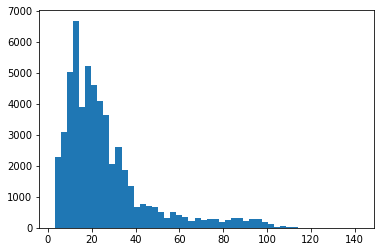

In [16]:
import matplotlib.pyplot as plt
plt.hist([len(i) for i in tokenized_train.values] + [len(i) for i in tokenized_test.values], bins=50)
None

In [17]:
max_len = 40

padded_train = pad_sequences(tokenized_train.values, maxlen=max_len, padding='post', truncating='post')
padded_test = pad_sequences(tokenized_test.values, maxlen=max_len, padding='post', truncating='post')
print(padded_train)
print('-------------------------------------------------------------')
print(padded_test)

[[   101    113   9926 ...   9640  18784  12030]
 [   101  68409 108578 ...      0      0      0]
 [   101   9294  12508 ...  11513   9682  54141]
 ...
 [   101   8933  13890 ...      0      0      0]
 [   101   9379  66016 ...      0      0      0]
 [   101   9659 118959 ...      0      0      0]]
-------------------------------------------------------------
[[  101  9405 62200 ...     0     0     0]
 [  101  9328 40032 ...     0     0     0]
 [  101 10709 86181 ...     0     0     0]
 ...
 [  101 62849 17655 ...     0     0     0]
 [  101  9706 16439 ... 13764 61250 10739]
 [  101  9434 20626 ...     0     0     0]]


In [18]:
print(padded_train.shape)
print(padded_test.shape)

(50000, 40)
(5000, 40)


### Masking
입력을 처리 할 때 추가 한 패딩을 무시(마스크)하도록 다른 변수를 만들어야 하는데, 이 것을 attention_mask 라 합니다.

In [19]:
attention_mask_train = np.where(padded_train !=0, 1, 0 )
attention_mask_test = np.where(padded_test !=0, 1, 0 )
print(attention_mask_train.shape)
print(attention_mask_test.shape)

(50000, 40)
(5000, 40)


## Model #1: Fine Tuning 시작

`model ()`함수는 BERT를 통해 문장을 실행. 처리 결과는`last_hidden_states`로 반환.

In [0]:
model.to(device)

input_ids_train = torch.tensor(padded_train).to(torch.int64)
attention_mask_train = torch.tensor(attention_mask_train)

input_ids_test = torch.tensor(padded_test).to(torch.int64)
attention_mask_test = torch.tensor(attention_mask_test)

In [0]:
from torch.utils.data import TensorDataset, DataLoader
BATCH_SIZE = 128

dataset_train = TensorDataset(input_ids_train, attention_mask_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE)

dataset_test = TensorDataset(input_ids_test, attention_mask_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE)

In [22]:
import time
s = time.time()

with torch.no_grad():
    last_hidden_states_train = []
    for batch in dataloader_train:

        hidden = model(batch[0].to(device), batch[1].to(device))

        if len(last_hidden_states_train) == 0:
            last_hidden_states_train = hidden[0].to("cpu")
        else:
            last_hidden_states_train = torch.cat((last_hidden_states_train, hidden[0].to("cpu")), dim=0)
            torch.cuda.empty_cache()

    last_hidden_states_test = []
    for batch in dataloader_test:

        hidden = model(batch[0].to(device), batch[1].to(device))

        if len(last_hidden_states_test) == 0:
            last_hidden_states_test = hidden[0].to("cpu")
        else:
            last_hidden_states_test = torch.cat((last_hidden_states_test, hidden[0].to("cpu")), dim=0)
            torch.cuda.empty_cache()

print(f"elapse time: {time.time() - s}")

elapse time: 473.8182876110077


In [23]:
print(last_hidden_states_train.shape)
print(last_hidden_states_test.shape)

torch.Size([50000, 40, 768])
torch.Size([5000, 40, 768])


- 필요한 출력 부분 만 슬라이스. 그것은 각 문장의 첫 번째 토큰에 해당하는 출력. 
- BERT가 문장 분류를하는 방식은 모든 문장의 시작 부분에`[CLS]`(분류 용)라는 토큰을 추가하는 것임. 해당 토큰에 해당하는 출력은 전체 문장에 대한 임베딩으로 간주 될 수 있음.

- 로지스틱 회귀 모델의 feature 로 사용되므로`features` 변수에 저장합니다.

In [24]:
features_train = last_hidden_states_train[:,0,:]
features_test = last_hidden_states_test[:,0,:]
print(features_train.shape)
print(features_test.shape)

torch.Size([50000, 768])
torch.Size([5000, 768])


어떤 문장이 긍정인지 부정인지를 나타내는 레이블을 `labels` 변수에 할당.

In [25]:
labels_train = torch.tensor(df_train['label'].values.astype("float32"))
labels_test = torch.tensor(df_test['label'].values.astype("float32"))

print(labels_train.shape)
print(labels_test.shape)

torch.Size([50000])
torch.Size([5000])


## LogisticRegression model 훈련

In [0]:
import torch.nn as nn

class LogisticRegression(nn.Module):
    def __init__(self, n_inputs):
        super().__init__()
        self.linear1 = nn.Linear(n_inputs, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(torch.relu(x))
        yhat = torch.sigmoid(self.linear3(torch.relu(x)))
        return yhat

In [27]:
classifier = LogisticRegression(features_train.shape[1])
classifier.to(device)

LogisticRegression(
  (linear1): Linear(in_features=768, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.1)

In [0]:
BATCH_SIZE = 64

dataset_train = TensorDataset(features_train, labels_train)
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE)

dataset_test = TensorDataset(features_test, labels_test)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE)

In [30]:
LOSS = []

for epoch in range(100):
    for i, (x, y) in enumerate(loader_train):
        yhat = classifier(x.to(device))
        loss = criterion(yhat.to("cpu"), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        LOSS.append(loss)
    if epoch % 20 == 0:
        print("epoch---", epoch)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch--- 0
epoch--- 20
epoch--- 40
epoch--- 60
epoch--- 80


In [0]:
accuracy = []
for x, y in loader_test:
    x, y = x.to(device), y.to(device)
    z = classifier(x)
    accuracy.append((sum(z > 0.5).item() / sum(y)).item())

In [32]:
np.mean(accuracy)

0.9149061856390555

In [0]:
x = '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나'
tokenized = tokenizer.encode(x, add_special_tokens=True)

In [34]:
tokenized

[101,
 100,
 119,
 119,
 119,
 9928,
 58823,
 30005,
 11664,
 9757,
 118823,
 30858,
 18227,
 119219,
 119,
 119,
 119,
 119,
 9580,
 41605,
 25486,
 12310,
 20626,
 23466,
 8843,
 118986,
 12508,
 9523,
 17196,
 16439,
 102]

In [35]:
tokenizer.decode(tokenized)

'[CLS] [UNK]... 포스터보고 초딩영화줄.... 오버연기조차 가볍지 않구나 [SEP]'

In [36]:
padded = pad_sequences([tokenized], maxlen=max_len, padding='post')
padded

array([[   101,    100,    119,    119,    119,   9928,  58823,  30005,
         11664,   9757, 118823,  30858,  18227, 119219,    119,    119,
           119,    119,   9580,  41605,  25486,  12310,  20626,  23466,
          8843, 118986,  12508,   9523,  17196,  16439,    102,      0,
             0,      0,      0,      0,      0,      0,      0,      0]],
      dtype=int32)

In [37]:
attention_mask = np.where(padded !=0, 1, 0 )
attention_mask

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [0]:
input_ids = torch.tensor(padded).to(torch.int64).to(device)
attention_mask = torch.tensor(attention_mask).to(device)

In [39]:
hidden = model(input_ids, attention_mask)
hidden[0].shape

torch.Size([1, 40, 768])

In [0]:
features = hidden[0][0 ,0, :].to("cpu").detach()

In [41]:
classifier(features.to(device)).item()

0.03743727132678032